# Lesson 3: Image Combination and Gridding Data

Rebekah Esmaili (bekah@umd.edu) Research Scientist, STC/JPSS
 
---


## Lesson Objectives
* You will learn to:
    * Create new imagery by combining single channels
    * Perform basic gridding operations to regularly spaced data
    * Save data into text and binary files, and plots as images
   
---

## What do I need?
* If you are really new to Python, I recommend using the binder links to run these notebooks remotely.
* If you have some experience, you can either install Anaconda locally on your laptop or on a remote server. There are some instructions in the main directory.
* I _do not recommend_ using system or shared Python installations unless you are advanced!

---

Datasets:
* Two GOES-16 level 1 radiance data files will be used to examine the NDVI:
    * Channel 2: OR_ABI-L1b-RadM1-M6C02_G16_s20192091147504_e20192091147562_c20192091147599.nc
    * Channel 3: OR_ABI-L1b-RadM1-M6C03_G16_s20192091147504_e20192091147562_c20192091148025.nc
* Two GOES-16 level 1 radiance data files will be used to examine the hurricane convection:
    * Channel 2: OR_ABI-L1b-RadM1-M6C02_G16_s20192091147504_e20192091147562_c20192091147599
    * Channel 13: OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc
* 3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B_thinned.nc: IMERG is a global 30-minute precipitation dataset.
    * NOTE: I removed fields, reduced the domain, and converted the original file to netCDF for this lesson. The original file is in HDF5 format and called 3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B.HDF5. Access the original file via [NASA's GPM website](https://gpm.nasa.gov/data/directory)
* sst.mon.ltm.1981-2010.nc: NOAA Extended Reconstructed Sea Surface Temperature (SST) V5 dataset

Start by importing several packages that we covered in the earlier lessons:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np, numpy.ma as ma
import pandas as pd
from cartopy import crs as ccrs
import scipy.interpolate

Scipy.interpolate has a lot of useful interpolation schemes. While not covered in this tutorial, [pyresample](https://pyresample.readthedocs.io/en/latest/) is a great package for more complex gridding operations and for irregularly spaced data.

## Combining multiple datasets

In the next example, we will construct the Normalized Difference Vegetation Index (NDVI) for a scene by combining multiple images from spectral bands. The NDVI is useful for looking at vegetation health, surface type, and can be used to look at burn scars after fires. Plants absorb light between 0.4 and 0.7 µm (visible, VIS) and reflect in 0.7 to 1.1 µm (Near infrared, NIR). NDVI is calculated using the following equation:
```
NDVI = (NIR — VIS)/(NIR + VIS)
```

Healthy vegetation will absorb more in the visible light and reflect more in the near IR, and thus have a higher NDVI value. Drier vegetation will absorb less visible light and reflect less near IR, resulting in a lower NDVI value. A value of 0 can be found in deserts where there is little to no vegetaion while values close to 1 indicate a high vegetation density (Source: https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php)

GOES-16 is a geostationary weather satellite that takes continuous imagery of a domain centered on the Atlantic Ocean. The Advanced Baseline Imager (ABI) takes images of the Earth using 16 spectral bands, which are also referred to as channels.

In [2]:
# Import ABI Channel 3 ()
fname = 'data/meso/OR_ABI-L1b-RadM1-M6C03_G16_s20192091147504_e20192091147562_c20192091148025.nc'
goesnc = xr.open_dataset(fname)
nearir = goesnc['Rad'].values

# Import ABI Channel 2
fname = 'data/meso/OR_ABI-L1b-RadM1-M6C02_G16_s20192091147504_e20192091147562_c20192091147599.nc'
goesnc = xr.open_dataset(fname)
vis = goesnc['Rad'].values

If you look at the size of the VIS channel and compare with the NIR channel, you'll see that the nearir is higher resolution.

In [3]:
vis.shape, nearir.shape

((2000, 2000), (1000, 1000))

The arrays need to match so that we can take the difference. There are more complicated gridding schemes, but for now, we can simply sample the VIS array so that we only keep every 2nd element. We can do this by using the double colon (::) in Numpy, which looks like:

In [4]:
vis = vis[::2, ::2]

Now, if we check the dimensions again, the shapes match:

In [5]:
vis.shape, nearir.shape

((1000, 1000), (1000, 1000))

We can now difference the two spectral channels to obtain the NDVI for the scene and afterwards, we make a plot of the resulting image.

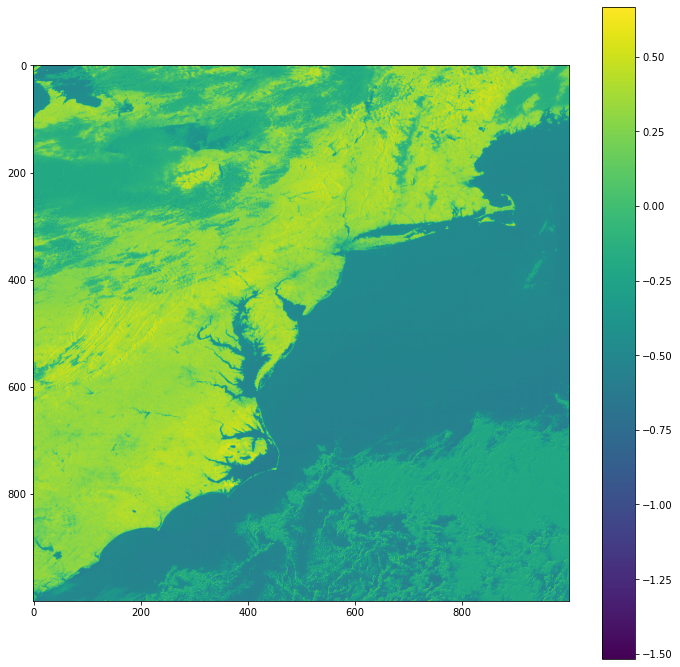

In [6]:
img = (nearir-vis)/(nearir+vis)

plt.figure(figsize=[12,12])
plt.imshow(img)
plt.colorbar()
plt.show()

---
**Exercise 1**: Combining images from two different channels
1. Open the two files using the netCDF4 library:
    * Channel 13: OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc
    * Channel 2: OR_ABI-L1b-RadM1-M3C02_G16_s20182822019282_e20182822019339_c20182822019374.nc
2. From each file, extract the 'Rad' variable (radiance) and save it to a new variable.
3. Check the dimensions, are they the same? If not, use the double colon (::) to subset the array and match the two array dimensions.
4. Take the difference between channel 2 and  channel 13 (Ch02 - C13) 
5. Make a plot using plt.imshow().
---

**Solution:**

## Changing the grid

We will often need to change grids when we compare data sources, such as models, satellite observations, and in situ data. There are many methods to do this. In the previous example, we had one channel that was 1000x1000 pixels and another that is 2000x2000. Since our goal was to display the data and not perform rigorous analysis, we dropped every other pixel. However, for a long-term trend analysis, we may want to use more sophisticated methods, such as interpolation. Below is a simple example, where we decrease the resolution (also called "coarsening", "aggregating," or "upscaling" the data).

Scipy.interpolate is useful sub-package gridding. In particular, the griddata function allows the user to pass a single or a list of unstructured points. The command and syntax looks like:

```python
scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')
```
* points: an array pair of x and y values (e.g. longitude and latitude)
* values: the corresponding "z" value at the x,y location. This needs to be 1-dimensional

There are three methods: 
* 'nearest' closest data point to (Xnew, Ynew)
* 'linear' a linear interpolation between the closest points to (Xnew, Ynew)
* 'cubic' a spline interpolation between the closest points to (Xnew, Ynew)

Below, we will import an IMERG dataset to look at a heavy rainfall episode over New Orleans, Lousiana, USA on August 11, 2016. The domain that we will study is 28N-33N, 94.0W-88.0W. IMERG is 0.1 x 0.1 degrees latitude and longitude; for our example below, we will change the grid to 0.5 x 0.5 degrees.

The code block below imports three variables:

* precipitationCal (3-dimensional)
* lat (1-dimensional)
* lon (1-dimensional)

precipitationCal is three dimensional \[time, lat, lon\] but there is only one time element. We will read in the data using the 0 index so that we are working only in two dimensions, latitude and longitude.

In [7]:
fname = 'data/3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B_thinned.nc'
imergv6 = xr.open_dataset(fname)
precip = imergv6['precipitationCal'][0,:,:].values
lat = imergv6['lat'].values
lon = imergv6['lon'].values

First, to convert precip from a 2-dimensioanl variable to 1-dimensional, we can again use the *.flatten()* command:

In [8]:
values = precip.flatten()

Next, we need to define our original/old grid that the data is natively in. Our *precip* array is 2-dimensional, but *lat* and *lon* are 1-dimensional. We can use the *np.meshgrid* command to project the data into 2-dimensions (*Xold* and *Yold*) and match the precipitation array size. However, we then need to convert it to a 1-dimensional array to match *values*.

Below, we use meshgrid to get the 2-dimensional x and y arrays. We use the *indexing='ij'* option because the latitudes start with a positive number and become negative, thus the origin is the upper left corner of the box (following matrix, or 'ij' formatting). If latitude started with negative values and became positive, then the origin would be in the bottom left (following the "standard" or "xy" formatting).

In [9]:
Xold, Yold = np.meshgrid(lon, lat, indexing='ij')

We now need to write Xold and Yold into a 1-dimensional form. Then, these will be stored as a pair in a Nx2 dimensional array.

First, we get the dimensions from value and create an array fileld with zeros using *np.zero*. We will overwrite the zeros with the flattened Xold and Yold arrays.

In [10]:
dims = (values.shape[0], 2)
points =  np.zeros(dims)

points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

We are done formatting our dataset!

Now we must define our new grid. We can use the mgrid function to do this, which will return two 2-dimensional X and Y meshes across our domain of choice:

```python
np.mgrid[x_start:x_stop:nx, y_start:y_stop:ny]
```

We could interpolate across the entire planet (180W-180E,90S-90N), but that will require more calculations than we need. To save time and the number of calculation, we will focus on our domain (28N-33N, 94.0W-88.0W, saved to the variable *coverage*). These values are the *_start, *_stop values in the code above.

The nx and ny variables are the number of points spanning the start and stop values, which is tricker to calculate. To count the number of points, we use the following formula:

```
int((x_stop - x_start)/grid_size)
```
Remember, our goal is to change the 0.1 x 0.1 degree grid to 0.5 x 0.5 degrees (*grid_size*). We use the int command because the numbers cannot have trailing decimals. Confusingly, mgrid requires nx and ny to be complex values (using *complex()*).

In the last step, we call mgrid to generate Xnew and Ynew!

In [11]:
grid_size=0.5

coverage = [-94.0, 28.0, -88.0, 33.0]

num_points_x = int((coverage[2] - coverage[0])/grid_size)
num_points_y = int((coverage[3] - coverage[1])/grid_size)

nx = complex(0, num_points_x)
ny = complex(0, num_points_y)

Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]

Finally, we can perform our interpolation!

In [12]:
gridOut = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')

Let's compare our results. We'll compare them side-by-side to the native resolution of the data:

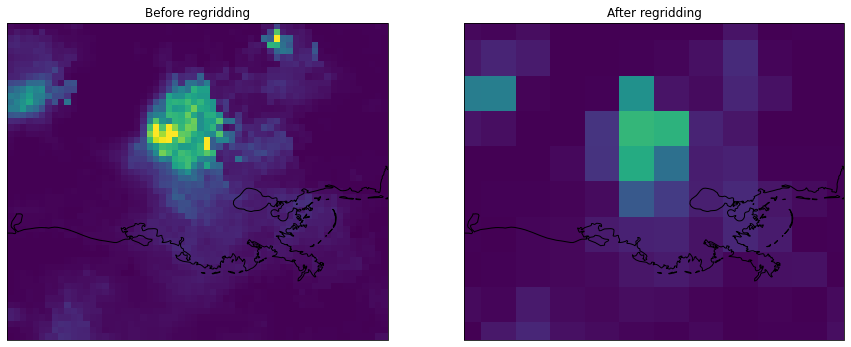

In [13]:
to_proj = ccrs.PlateCarree()
from_proj = ccrs.PlateCarree()
extent = [-94.0, -88.0, 28.0,  33.0]

fig = plt.figure(figsize=[15,15])

ax=plt.subplot(121, projection=to_proj)
ax.coastlines('10m')
ax.set_extent(extent)

ax.set_title("Before regridding")
ax.pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)


ax=plt.subplot(122, projection=to_proj)
ax.coastlines('10m')
ax.set_extent(extent)

ax.set_title("After regridding")
ax.pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=20)

plt.show()

---
**Exercise 2**: Regridding a regularly spaced dataset

We will practice converting a 2 x 2 degree, regularly spaced grid to a 5-degree regularly spaced grid. This example has a lot of steps but closely follows the IMERG regridding example. We will use NOAA Extended Reconstructed Sea Surface Temperature (SST) V5 dataset, which has 2 degree spacing. This dataset is similar the the IMERG dataset, with the following differences:
* The longitude coordinates are expressed from 0 to 360 degrees; IMERG is from -180 to 180 degrees.
* The SST dataset has more than one time coordinate, we will use the first one (index 0), which corresponds to January. Feel free to look at any other ones!

Here are the steps:
1. Import sst.mon.ltm.1981-2010.nc, which has monthly long-term mean SST values.
2. Extract the following variables:
    * 'sst' is a 3-dimensional variable, time, lat, and lon. We will only import the first month (index 0), so use \[0,:,:\]
    * 'lat', 'lon' are 1-dimensional variables. Latitude goes from negative to positive, and longitude spans 0 to 360.
3. Convert sst to 1-dimensional using *.flatten()*.    
4. Define a 1-dimensional list of the original 2 degree lat, lon grid.
    * Create a 2-dimensional lat, lon using the np.meshgrid ( e.g. np.meshgrid(lon, lat, indexing='xy'))
5. Define the new lat, lon grid that has 5 degrees of spacing
    * Create a new variable called gridsize
    * Calculate the number of longitude points and latitude 
6. Interpolate the original SST to the new 5-degree grid.
    * Flatten (using .flatten() ) the ssts so that it is 1-dimensional
7. Create a plot showing the old and the new data.
    * The data are from 0 to 360, we need to set the central longitude to -180 on the map!
    * You can change the variable names in the pcolormesh lines to reflect any differences in your variable names.
    
```python
fig = plt.figure(figsize=[15,15])

to_proj = ccrs.PlateCarree(central_longitude=-180)
from_proj = ccrs.PlateCarree()

ax = plt.subplot(projection=to_proj)
ax.coastlines('10m', color='black')

# For the original 2-degree grid
ax.pcolormesh(Xold, Yold, sst, vmin=0, vmax=30, transform=from_proj)

# For the new 5-degree grid
#ax.pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=30, transform=from_proj)


plt.show()
```

---

**Solution:**

## Exporting data and Figures

### Saving as csv:

The Pandas *to_csv* is convenient for quickly saving files. The option *index=False* suppress the indices of the DataFrame (which are printed to the left of the DataFrame) from being printed to file.

In [14]:
name = ['GOES-16', 'IceSat-2', 'Himawari']
agency = ['NOAA', 'NASA', 'JAXA']
orbit = ['GEO', 'LEO', 'GEO']

df = pd.DataFrame({'name': name,
                   'agency': agency,
                   'orbit': orbit})

df.to_csv('satellites.csv', index=False)

### Saving as a binary file

NumPy binary files (.npz) are geared towards arrays, which can be multi-dimensional. These are useful for quickly storing large datasets.

In [15]:
np.savez('satnames', name=name, agency=agency, orbit=orbit)

In [16]:
npzfile = np.load('satnames.npz')
npzfile.files
npzfile.close()

### Saving figures

Normally, we end out plots with plt.show() to display them inline. Instead, use *plt.savefig()*. The second argument (*bbox_inches*) refers to the whitespace around the plot, it is optional.  

In [17]:
fig = plt.figure(figsize=[8,8])

ax=plt.subplot(projection=to_proj)
ax.coastlines('10m')
ax.set_extent(extent)

ax.pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)

plt.savefig('precip.png',  bbox_inches='tight') 
plt.close()


## Scripting with Python

### Creating scripts from Jupyter Notebooks
One of the simplest ways to create a script is to convert an existing Jupyter notebook. As an example, we will created a notebook named script_example that only contains one line of code: print(“Hello Earth”). You can convert any Jupyter Notebook to a script by going to File → Download as → Python (.py):
 

This will download a new file (script_example.py) to your computer. If you open the file using your text editor, you will see:

```

#!/usr/bin/env python
# coding: utf-8

# In[1]:

print("Hello Earth")
```

You will notice that the script contains the line numbers (*ln\[1\]*), which in my opinion is unnecessary and should be removed from your script. Beginners, you can delete this extra formatting from your file.

### Running Python scripts from the command line

Now you are finished editing the code and you probably want to run it. There are two ways you can run Python scripts:

1. Using the command line interpreter
2. Using iPython

iPython is an interactive command line that allows you to run code in chunks. In fact, Jupyter Notebook is built using iPython, which explains the similarity in behavior.
 
* Windows: I suggest using the Anaconda Prompt which you can access from the start menu or using Anaconda Navigator. 
* MacOs/Linux: open the Terminal app. 

Once the command line is open, you start in a default location. For example, if you are using Windows and launch the Anaconda Prompt you will see:

```
(base) C:\Users\rebekah>
```

Now, navigate to where our script is. To do this, you will change directories using the cd command. For example, if your code is stored in C:\Documents\Python, you can type:

```

cd C:\Documents\Python
```

The command line will now be updated showing:

```
(base) C:\Documents\Python>
```

Now that you are in the right place, you can call the Python interpreter, which to convert your code into a format that your computer can understand and executes the command. If you installed Anaconda, this includes a Python 3 interpreter (*python3*). So, to run the script, type:

```
python3 hello_world.py
```

If successful, “Hello Earth” should print to your screen.

A second method is to use iPython, which allows you to open Python in interactive mode. Unlike the command line method, iPython will let you run code line-by-line. So, like Jupyter Notebook, you have the option to copy and paste you code from the text editor in chunks into the iPython window. You can also call the entire script inside iPython. This is done by starting iPython and using the command %run \[script name\].py. Below is a capture from my terminal:

```
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Type 'copyright', 'credits' or 'license' for more information
IPython 7.12.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: %run script_example.ipynb
Hello Earth
```

One advantage of using iPython is that after the script finishes running, variables that were generated in the script are still in memory. Then, you can print or operate on the variables to either debug or to develop your code further. 

You may have noted two differences in workflow for write code in scripts versus notebooks, (1) that code cannot be inline and (2) the program must run fully to the end.


### Handling output when scripting

In the previous example, you printed text to the screen but Python’s capable of saving figures and data. To save plots, replace *plt.show()* with the *plt.savefig()* command.

It is possible to directly display your graphics using the X11 protocol (by default in Linux) with XQuartz (Mac) or PuTTy (Windows). 

I typically discourage this because satellite imagery tends to be very large and thus slow to display remotely. From my experience, it is usually faster to write an image to a file and then view the plot after it is fully rendered.

## Summary:

You learned:

* How to combine satellite imagery
* Change grid size from regularly-spaced data
* How to save data and graphics

## Conclusion

I hope you feel empowered find relevant satellite data for your project are equipped with the tools to visualize it. Practice regularly (daily!) to improve your skills. Here are some ways you can continue your journey:

* Downlaod data. You can access data from ESA (https://earth.esa.int/eogateway/), NOAA’s threads data server: https://www.ncei.noaa.gov/thredds/catalog.html, or NASA's [Earthdata](https://earthdata.nasa.gov/) portals.
* Read. 
    * [Python for Data Science](https://jakevdp.github.io/PythonDataScienceHandbook/) (free)
    * Python Programming and Visualization for Scientists by Alex DeCaria (not free)
    * Python Machine Learning by Wei-Meng Lee (not free)
* Watch.
    * [CS Dojo](https://www.youtube.com/channel/UCxX9wt5FWQUAAz4UrysqK9A) on YouTube has a lot of short, fun Python tutorials.
    * [Coursera](https://www.coursera.org/learn/interactive-python-1?specialization=computer-fundamentals) has some fundamental interactive Python courses if you want more structure.
* Connect with an online community, such as Pangeo (https://discourse.pangeo.io/)